# Real Vs Fake Job Prediction

## Project Deliverable #3 — Final Code

due 04/29/2022

**Group 38**

Ayush Baral | ab5247

Chaewon Park | cp3227

Erin Josephine Donnelly | ejd2170

Mukesh Bangalore Renuka | mb4862

Smarth Gupta | sg3868

In [ ]:
!pip install category_encoders

In [ ]:
# imports
import os
import shutil
import time
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE


## Data and Preprocessing

Link to dataset: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in the data
path = '/content/drive/MyDrive/AML Group Project'
foldername = 'data'
filename = 'fake_job_postings.csv'
postings_orig = pd.read_csv(os.path.join(path, foldername, filename))

# un comment to display dataframe
# postings_orig

In [ ]:
# drop, and department; there are too many missing values
# drop job_id; irrelevant
postings = postings_orig.copy()
postings.drop(columns=['department', 'job_id'], inplace=True)

In [ ]:
# summary data elements
print('Shape: ', postings.shape)
num_fraud = sum(postings['fraudulent'])
print('Number of fraudulent examples:', num_fraud)
print('Number of legitimate examples:', postings.shape[0]-num_fraud)

Shape:  (17880, 16)
Number of fraudulent examples: 866
Number of legitimate examples: 17014


In [ ]:
postings['has_description'] = postings['description'].str.len()
postings['has_company_profile'] = postings['company_profile'].str.len()
postings['has_requirements'] = postings['requirements'].str.len()
postings['has_benefits'] = postings['benefits'].str.len()

In [ ]:
postings['has_description'] = (postings['has_description'] > 0).astype(int)
postings['has_company_profile'] = (postings['has_company_profile'] > 0).astype(int)
postings['has_requirements'] = (postings['has_requirements'] > 0).astype(int)
postings['has_benefits'] = (postings['has_benefits'] > 0).astype(int)

In [ ]:
categorical_target_columns = ['industry', 'function', 'location']
categorical_columns = ["employment_type", "required_experience", "required_education"]
text_columns = ['description', 'company_profile', 'requirements', 'benefits']
text_len_columns = ['has_description', 'has_company_profile', 'has_requirements', 'has_benefits']

In [ ]:
# separate features from labels
postings_text = postings[text_columns]
postings = postings.drop(columns=['title', 'salary_range']+text_columns)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
postings['employment_type'] = postings['employment_type'].astype(str)
postings['required_experience'] = postings['required_experience'].astype(str)
postings['required_education'] = postings['required_education'].astype(str)

In [ ]:
postings['employment_type'] = postings['employment_type'].replace('', 'NA')
postings['employment_type'] = postings['employment_type'].replace('Other', 'NA')
postings['required_experience'] = postings['required_experience'].replace('', 'NA')
postings['required_experience'] = postings['required_experience'].replace('Not Applicable', 'NA')
postings['required_education'] = postings['required_education'].replace('', 'NA')
postings['required_education'] = postings['required_education'].replace('Other', 'NA')
postings['required_education'] = postings['required_education'].replace('Unspecified', 'NA')

In [ ]:
# one hot encoding (categorial features)
for c in categorical_columns:
    encoded = pd.get_dummies(postings[c], drop_first=True)
    postings = pd.concat([postings, encoded], axis=1)

postings = postings.drop(categorical_columns, axis = 1)

In [ ]:
# function to plot confusion matrices
def plotConfusionMatrix(y_preds, y_test, samp_method, mod_type):
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=y_preds)).plot()
    if mod_type.lower() == 'dtc':
        plt.title('Confusion Matrix of {} Decision Tree'.format(samp_method))
    elif mod_type.lower() == 'rfc':
        plt.title('Confusion Matrix of {} Random Forest'.format(samp_method))
    elif mod_type.lower() == 'lr':
        plt.title('Confusion Matrix of {} Logistic Regression'.format(samp_method))
    elif mod_type.lower() == 'knn':
        plt.title('Confusion Matrix of {} KNN'.format(samp_method))
    else:
        plt.title('Confusion Matrix of {} SVM'.format(samp_method))
    plt.show()

In [ ]:
def buildTrainEvaluate(X_dev, y_dev, X_test, y_test, model_type='dtc', sampling_method='Default', num_components=20):
    
    pca = None
    weights = None
    
    if sampling_method.lower() == 'weighted':
        weights = 'balanced'
            
    if model_type.lower() == 'dtc':
        print('\nDecision Tree Classifier')
        model = DecisionTreeClassifier(class_weight=weights, random_state=42)  
    elif model_type.lower() == 'rfc':
        print('\nRandom Forest Classifier')
        model = RandomForestClassifier(class_weight=weights, random_state=42)
    elif model_type.lower() == 'svm':
        print('\nSVM')
        pca = TruncatedSVD(n_components=num_components, random_state=42)
        model = SVC(class_weight=weights, random_state=42)
    elif model_type.lower() == 'lr':
        print('\nLogistic Regression')
        model = LogisticRegression(max_iter= 800)
    
    elif model_type.lower() == 'knn':
        print('\nKNN')
        model = KNeighborsClassifier(n_neighbors=3)

    else:
        valid_model_types = ['dtc', 'rfc', 'svm', 'lr', 'knn']
        print('\nError: Please choose a valid model types:\n', valid_model_types)
        return
     
    if sampling_method.lower() == 'ros':
        print('+ Random Over Sampler')
        method = RandomOverSampler(random_state=42)
    elif sampling_method.lower() == 'smote':
        print('+ SMOTE')
        method = SMOTE(random_state=42)
    else:
        method = None
        if sampling_method.lower() == 'weighted':
            print("+ 'balanced' Class Weights")
    
    imb_pipe = imb_make_pipeline(steps=[
                                    ('fix_imb', method),
                                    ('fix_sparse', pca),
                                    ('model', model)
                                    ])
    imb_pipe.fit(X_dev, y_dev)
    preds_dev = imb_pipe.predict(X_dev)
    preds = imb_pipe.predict(X_test)
    print('\tDevelopment accuracy: {:.4f}'.format(accuracy_score(y_dev, preds_dev)))
    print('\tDevelopment recall: {:.4f}'.format(recall_score(y_dev, preds_dev)))
    print('\tTest accuracy: {:.4f}'.format(accuracy_score(y_test, preds)))
    print('\tTest recall: {:.4f}'.format(recall_score(y_test, preds)))
    
    plotConfusionMatrix(preds, y_test, sampling_method, model_type)

    return(imb_pipe, preds)


In [ ]:
# display the final dataframe
postings

,location,telecommuting,has_company_logo,has_questions,industry,function,fraudulent,has_description,has_company_profile,has_requirements,...,High School or equivalent,Master's Degree,NA,Professional,Some College Coursework Completed,Some High School Coursework,Vocational,Vocational - Degree,Vocational - HS Diploma,nan
0,"US, NY, New York",0,1,0,NaN,Marketing,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,"NZ, , Auckland",0,1,0,Marketing and Advertising,Customer Service,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,"US, IA, Wever",0,1,0,NaN,NaN,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,"US, DC, Washington",0,1,0,Computer Software,Sales,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,"US, FL, Fort Worth",0,1,1,Hospital & Health Care,Health Care Provider,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,"CA, ON, Toronto",0,1,1,Computer Software,Sales,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
17876,"US, PA, Philadelphia",0,1,1,Internet,Accounting/Auditing,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
17877,"US, TX, Houston",0,0,0,NaN,NaN,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
17878,"NG, LA, Lagos",0,0,1,Graphic Design,Design,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


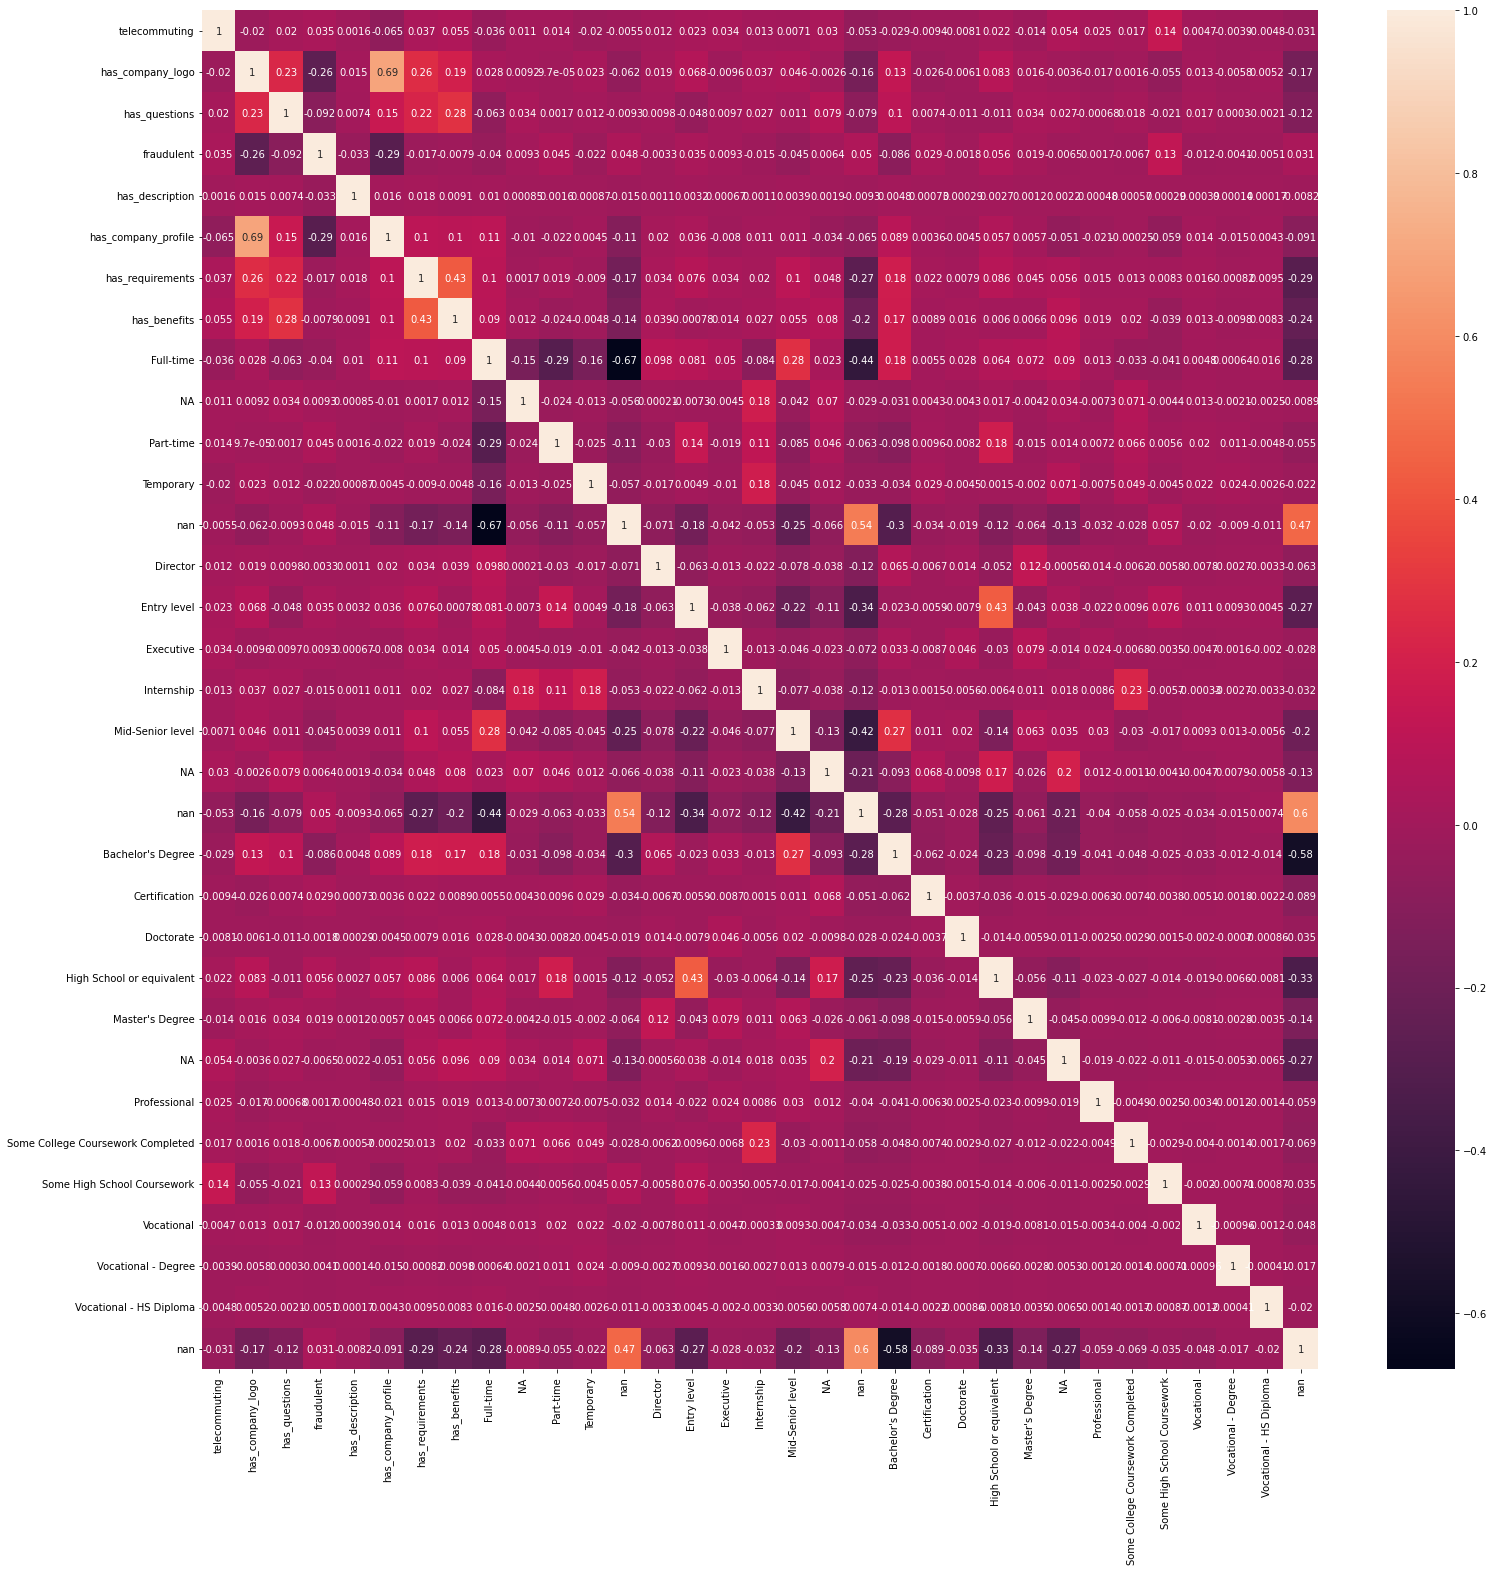

features to drop ['NA', 'nan', 'NA', 'nan', 'NA', 'nan']


In [ ]:
## check correlation
import seaborn as sns
import matplotlib.pyplot as plt

#code here
fig = plt.figure(figsize=(25,25))
# Create correlation matrix
corr_matrix = postings.corr()

sns.heatmap(corr_matrix, annot=True)
plt.show()


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)==1)
# Find features with correlation greater than 0.90
features_to_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]
print("features to drop", features_to_drop)

In [ ]:
# Drop correlated features 
postings.drop(features_to_drop, axis=1, inplace=True)

## Method 1: Only Non-Text Features

In [ ]:
postings_dev, postings_test = train_test_split(postings, test_size=0.2, random_state=42, stratify = postings['fraudulent'])

In [ ]:
from category_encoders import TargetEncoder

target_encoder = TargetEncoder()
postings_dev[categorical_target_columns] = target_encoder.fit_transform(postings_dev[categorical_target_columns], postings_dev['fraudulent'])
postings_test[categorical_target_columns] = target_encoder.transform(postings_test[categorical_target_columns], postings_test['fraudulent'])

In [ ]:
X_dev_non_text = np.array(postings_dev.drop(columns=['fraudulent']))
y_dev_non_text = postings_dev['fraudulent']

X_test_non_text = np.array(postings_test.drop(columns=['fraudulent']))
y_test_non_text = postings_test['fraudulent']

### Method 1 — Logistic Regression


Logistic Regression
	Development accuracy: 0.9676
	Development recall: 0.4228
	Test accuracy: 0.9636
	Test recall: 0.3006


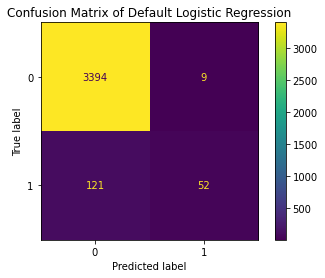


Logistic Regression
+ Random Over Sampler
	Development accuracy: 0.8868
	Development recall: 0.8817
	Test accuracy: 0.8798
	Test recall: 0.8150


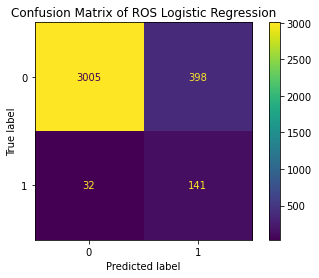


Logistic Regression
+ SMOTE
	Development accuracy: 0.8918
	Development recall: 0.8874
	Test accuracy: 0.8826
	Test recall: 0.8035


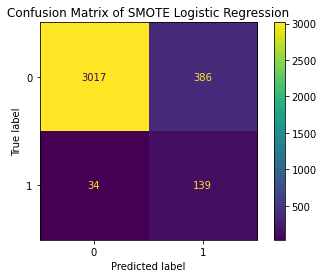


Logistic Regression
+ 'balanced' Class Weights
	Development accuracy: 0.9676
	Development recall: 0.4228
	Test accuracy: 0.9636
	Test recall: 0.3006


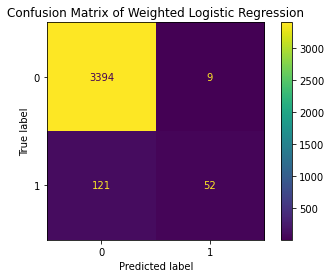

In [ ]:
# Logistic Regression
pipe_default_lr, preds_default_lr = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'lr')
pipe_ros_lr, preds_ros_lr = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'lr', 'ROS')
pipe_smote_lr, preds_smote_lr = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'lr', 'SMOTE')
pipe_weighted_lr, preds_weighted_lr = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'lr', 'Weighted')

### Method 1 — K-Nearest Neighbors


KNN
	Development accuracy: 0.9824
	Development recall: 0.7648
	Test accuracy: 0.9715
	Test recall: 0.5838


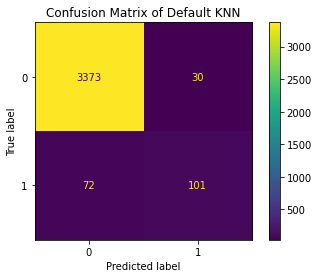


KNN
+ Random Over Sampler
	Development accuracy: 0.9858
	Development recall: 0.9740
	Test accuracy: 0.9606
	Test recall: 0.7052


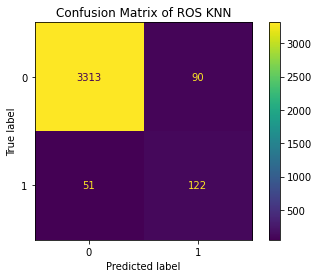


KNN
+ SMOTE
	Development accuracy: 0.9804
	Development recall: 0.9625
	Test accuracy: 0.9547
	Test recall: 0.7168


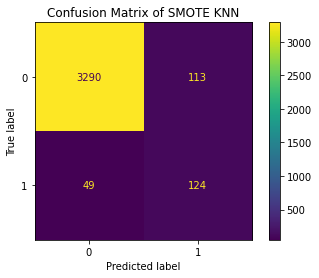


KNN
+ 'balanced' Class Weights
	Development accuracy: 0.9824
	Development recall: 0.7648
	Test accuracy: 0.9715
	Test recall: 0.5838


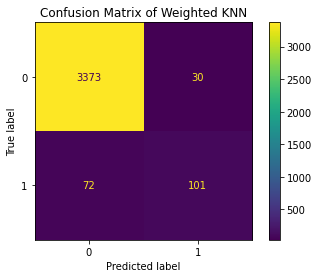

In [ ]:
# KNN
pipe_default_knn, preds_default_knn = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'knn')
pipe_ros_knn, preds_ros_knn = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'knn', 'ROS')
pipe_smote_knn, preds_smote_knn = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'knn', 'SMOTE')
pipe_weighted_knn, preds_weighted_knn = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'knn', 'Weighted')

### Method 1 — Decision Trees


Decision Tree Classifier
	Development accuracy: 0.9966
	Development recall: 0.9683
	Test accuracy: 0.9662
	Test recall: 0.6474


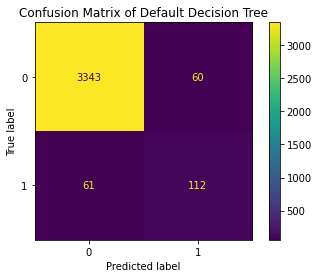


Decision Tree Classifier
+ Random Over Sampler
	Development accuracy: 0.9901
	Development recall: 0.9986
	Test accuracy: 0.9614
	Test recall: 0.6763


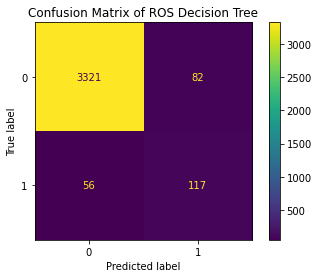


Decision Tree Classifier
+ SMOTE
	Development accuracy: 0.9958
	Development recall: 0.9784
	Test accuracy: 0.9622
	Test recall: 0.6994


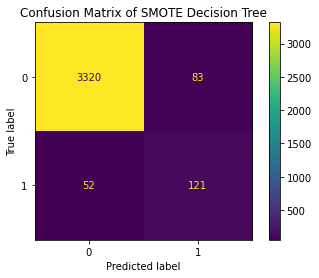


Decision Tree Classifier
+ 'balanced' Class Weights
	Development accuracy: 0.9901
	Development recall: 0.9986
	Test accuracy: 0.9622
	Test recall: 0.6647


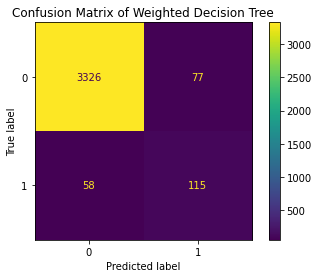

In [ ]:
# decision tree classifiers
pipe_default_dtc, preds_default_dtc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'dtc')
pipe_ros_dtc, preds_ros_dtc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'dtc', 'ROS')
pipe_smote_dtc, preds_smote_dtc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'dtc', 'SMOTE')
pipe_weighted_dtc, preds_weighted_dtc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text, 'dtc', 'Weighted')

### Method 1 — Random Forest


Random Forest Classifier
	Development accuracy: 0.9966
	Development recall: 0.9697
	Test accuracy: 0.9790
	Test recall: 0.6590


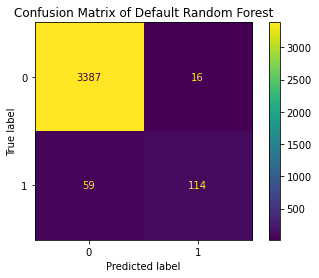


Random Forest Classifier
+ Random Over Sampler
	Development accuracy: 0.9901
	Development recall: 0.9986
	Test accuracy: 0.9681
	Test recall: 0.6532


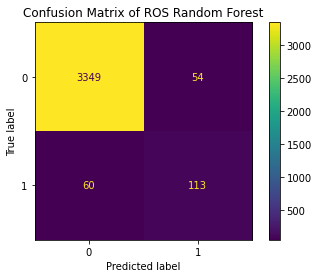


Random Forest Classifier
+ SMOTE
	Development accuracy: 0.9958
	Development recall: 0.9827
	Test accuracy: 0.9681
	Test recall: 0.6994


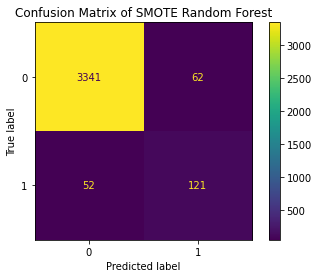


Random Forest Classifier
+ 'balanced' Class Weights
	Development accuracy: 0.9926
	Development recall: 0.9942
	Test accuracy: 0.9729
	Test recall: 0.6532


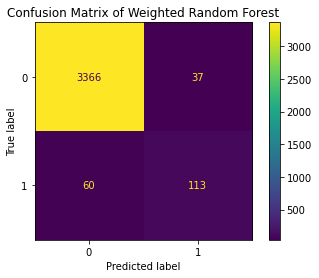

In [ ]:
# random forest classifiers
pipe_default_rfc, preds_default_rfc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text,'rfc')
pipe_ros_rfc, preds_ros_rfc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text,'rfc', 'ROS')
pipe_smote_rfc, preds_smote_rfc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text,'rfc', 'SMOTE')
pipe_weighted_rfc, preds_weighted_rfc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text,'rfc', 'Weighted')


### Method 1 —SVM


SVM
	Development accuracy: 0.9675
	Development recall: 0.3781
	Test accuracy: 0.9611
	Test recall: 0.2428


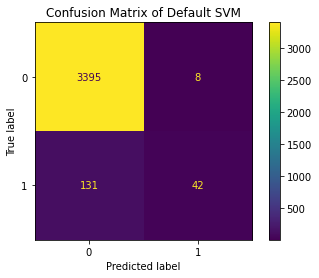


SVM
+ Random Over Sampler
	Development accuracy: 0.9090
	Development recall: 0.9264
	Test accuracy: 0.9004
	Test recall: 0.8497


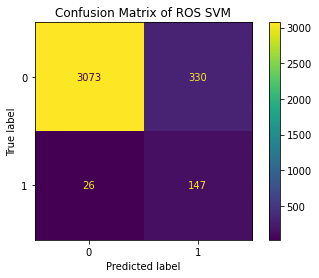


SVM
+ SMOTE
	Development accuracy: 0.9189
	Development recall: 0.9048
	Test accuracy: 0.9100
	Test recall: 0.8092


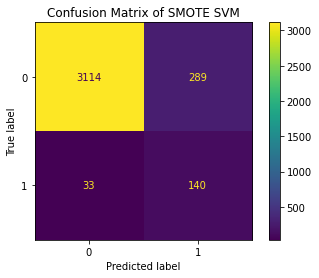


SVM
+ 'balanced' Class Weights
	Development accuracy: 0.9009
	Development recall: 0.9134
	Test accuracy: 0.8937
	Test recall: 0.8266


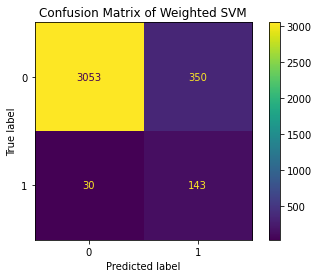

In [ ]:
# SVM classifiers
pipe_default_rfc, preds_default_rfc = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text,'svm')
pipe_ros_svm, preds_ros_svm = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text,'svm', 'ROS')
pipe_smote_svm, preds_smote_svm = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text,'svm', 'SMOTE')
pipe_weighted_svm, preds_weighted_svm = buildTrainEvaluate(X_dev_non_text, y_dev_non_text, X_test_non_text, y_test_non_text,'svm', 'Weighted')


### Method 1 — Performance Curves

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

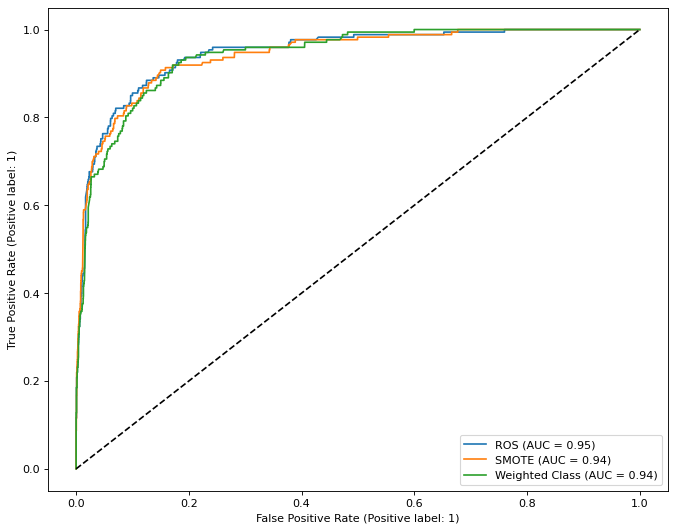

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

from sklearn.metrics import plot_roc_curve

classifiers = [pipe_ros_svm, pipe_smote_svm, pipe_weighted_svm]
name = ["ROS", "SMOTE", "Weighted Class"]

ax = plt.gca()
for index in range(len(classifiers)):
    plot_roc_curve(classifiers[index], X_test_non_text, y_test_non_text, ax = ax, name= name[index])
plt.plot([0,1],[0,1], 'k--')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

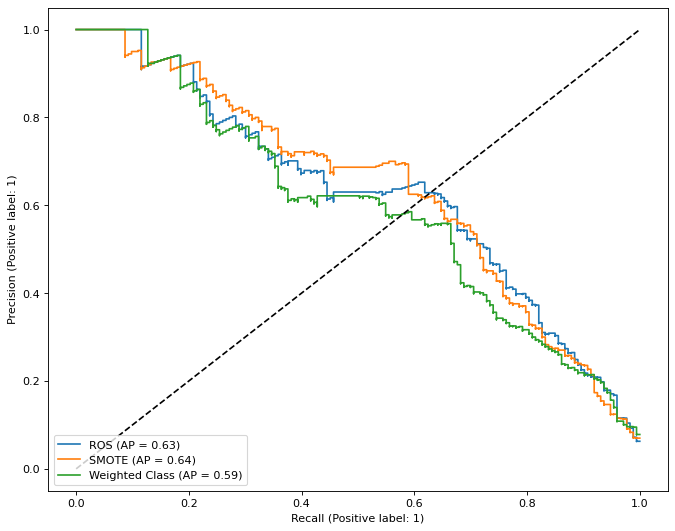

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

from sklearn.metrics import plot_precision_recall_curve

classifiers = [pipe_ros_svm, pipe_smote_svm, pipe_weighted_svm]
name = ["ROS", "SMOTE", "Weighted Class"]

ax = plt.gca()
for index in range(len(classifiers)):
    plot_precision_recall_curve(classifiers[index], X_test_non_text, y_test_non_text, ax = ax, name= name[index])
plt.plot([0,1],[0,1], 'k--')

## Preprocessing Text Features

In [ ]:
# combine all text features into a single feature
punctuation = r'[{}]'.format(string.punctuation)
postings_text['all_text'] = ''
postings_text = postings_text.fillna('')
for feat in postings_text.columns:
    postings_text[feat] = postings_text[feat].str.replace(punctuation, ' ', regex=True)
    postings_text[feat] = postings_text[feat].str.lower()
    postings_text['all_text'] += postings_text[feat]

In [ ]:
postings_all_text = postings_text.drop(columns=text_columns)

In [ ]:
def lemma_text(text):
    token_words = word_tokenize(text)
    lemmatize_text = [lemmatizer.lemmatize(word) for word in token_words]
    return " ".join(lemmatize_text)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# lemmatize
postings_all_text['lemmas'] = ''
lemmatizer = WordNetLemmatizer()
postings_lemmas = [lemma_text(test) for test in postings_all_text['all_text']]
postings_all_text['lemmas'] += postings_lemmas

## Method 2: Using Count Vectorizer for Text Features

In [ ]:
postings_count = pd.concat([postings, postings_all_text], axis= 1)

In [ ]:
postings_count_dev, postings_count_test = train_test_split(postings_count, test_size=0.2, random_state=42, stratify = postings_count['fraudulent'])

In [ ]:
from category_encoders import TargetEncoder

target_encoder = TargetEncoder()
postings_count_dev[categorical_target_columns] = target_encoder.fit_transform(postings_count_dev[categorical_target_columns], postings_count_dev['fraudulent'])
postings_count_test[categorical_target_columns] = target_encoder.transform(postings_count_test[categorical_target_columns], postings_count_test['fraudulent'])

In [ ]:
X_dev_text = postings_count_dev.drop(columns=['fraudulent'])
y_dev_text = postings_count_dev['fraudulent']

X_test_text = postings_count_test.drop(columns=['fraudulent'])
y_test_text = postings_count_test['fraudulent']

In [ ]:
vector_words = CountVectorizer(stop_words='english', min_df=100, max_features=128)
X_dev_embeddings = vector_words.fit_transform(X_dev_text['lemmas'].reset_index()['lemmas'])
X_test_embeddings = vector_words.transform(X_test_text['lemmas'].reset_index()['lemmas'])

In [ ]:
X_dev_text = pd.concat([X_dev_text.reset_index(), pd.DataFrame(X_dev_embeddings.toarray())], axis=1)
X_test_text = pd.concat([X_test_text.reset_index(), pd.DataFrame(X_test_embeddings.toarray())], axis=1)

In [ ]:
X_dev_text.drop(columns=['lemmas', 'all_text', 'index'], inplace=True, errors='ignore')
X_test_text.drop(columns=['lemmas', 'all_text', 'index'], inplace=True, errors='ignore')

In [ ]:
X_dev_text = np.array(X_dev_text)
X_test_text = np.array(X_test_text)

### Method 2 — Logistic Regression


Logistic Regression
	Development accuracy: 0.9759
	Development recall: 0.5974
	Test accuracy: 0.9726
	Test recall: 0.5318


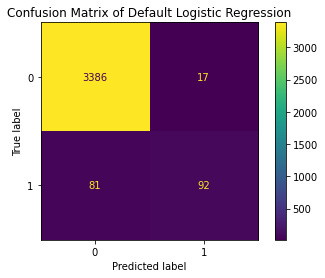


Logistic Regression
+ Random Over Sampler
	Development accuracy: 0.9151
	Development recall: 0.9293
	Test accuracy: 0.9100
	Test recall: 0.8728


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


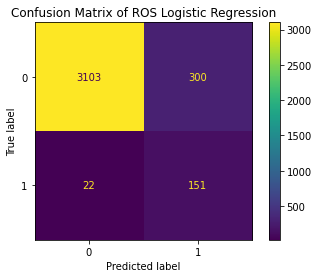


Logistic Regression
+ SMOTE
	Development accuracy: 0.9341
	Development recall: 0.9048
	Test accuracy: 0.9304
	Test recall: 0.8439


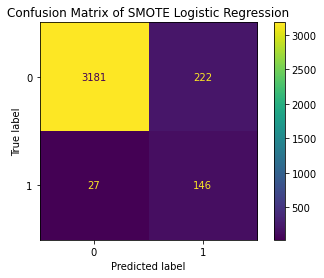


Logistic Regression
+ 'balanced' Class Weights
	Development accuracy: 0.9759
	Development recall: 0.5974
	Test accuracy: 0.9726
	Test recall: 0.5318


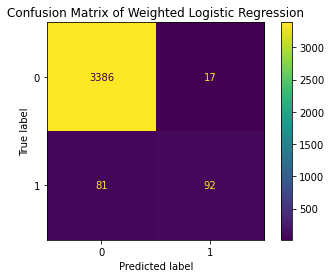

In [ ]:
# Logistic Regression
pipe_default_lr, preds_default_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr')
pipe_ros_lr, preds_ros_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'ROS')
pipe_smote_lr, preds_smote_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'SMOTE')
pipe_weighted_lr, preds_weighted_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'Weighted')

### Method 2 — K-Nearest Neighbors


KNN
	Development accuracy: 0.9833
	Development recall: 0.7850
	Test accuracy: 0.9732
	Test recall: 0.6590


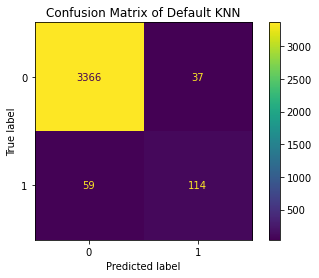


KNN
+ Random Over Sampler
	Development accuracy: 0.9812
	Development recall: 1.0000
	Test accuracy: 0.9583
	Test recall: 0.7746


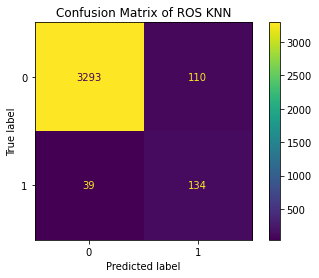


KNN
+ SMOTE
	Development accuracy: 0.9339
	Development recall: 1.0000
	Test accuracy: 0.8853
	Test recall: 0.8786


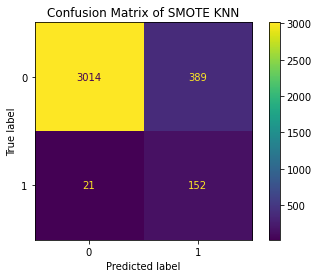


KNN
+ 'balanced' Class Weights
	Development accuracy: 0.9833
	Development recall: 0.7850
	Test accuracy: 0.9732
	Test recall: 0.6590


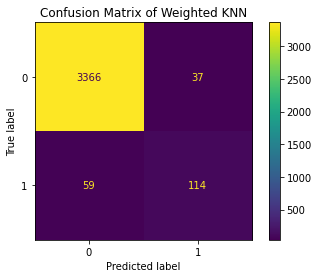

In [ ]:
# KNN
pipe_default_knn, preds_default_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn')
pipe_ros_knn, preds_ros_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'ROS')
pipe_smote_knn, preds_smote_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'SMOTE')
pipe_weighted_knn, preds_weighted_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'Weighted')

### Method 2 — Decision Trees


Decision Tree Classifier
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9667
	Test recall: 0.6821


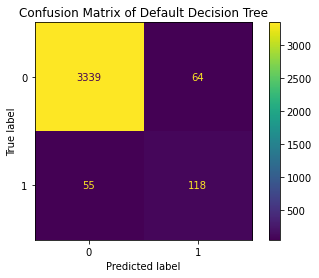


Decision Tree Classifier
+ Random Over Sampler
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9642
	Test recall: 0.5838


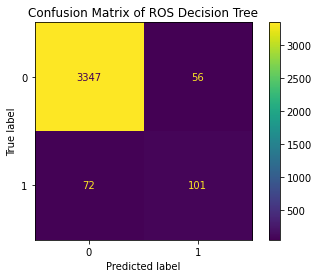


Decision Tree Classifier
+ SMOTE
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9622
	Test recall: 0.6416


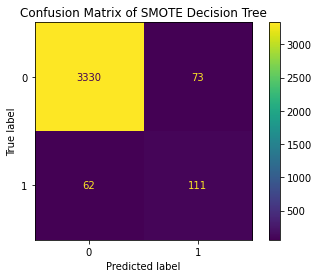


Decision Tree Classifier
+ 'balanced' Class Weights
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9676
	Test recall: 0.5954


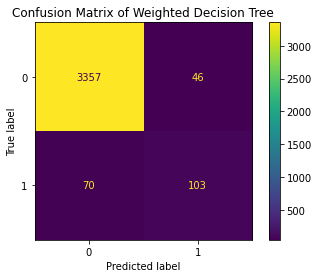

In [ ]:
# decision tree classifiers
pipe_default_dtc, preds_default_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', num_components=100)
pipe_ros_dtc, preds_ros_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'ROS', num_components=100)
pipe_smote_dtc, preds_smote_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'SMOTE', num_components=100)
pipe_weighted_dtc, preds_weighted_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'Weighted', num_components=100)

### Method 2 — Random Forest


Random Forest Classifier
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9810
	Test recall: 0.6127


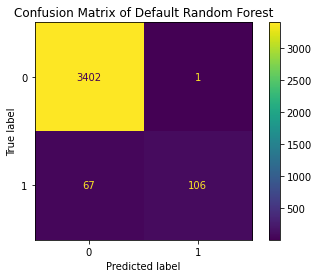


Random Forest Classifier
+ Random Over Sampler
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9790
	Test recall: 0.6243


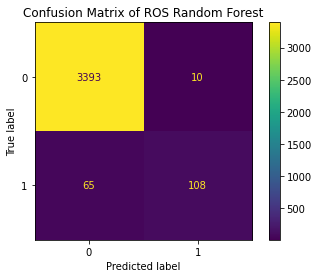


Random Forest Classifier
+ SMOTE
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9796
	Test recall: 0.6474


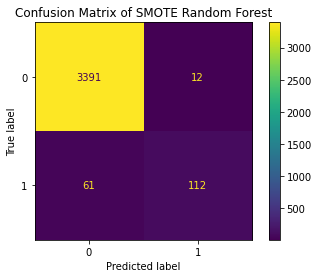


Random Forest Classifier
+ 'balanced' Class Weights
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9762
	Test recall: 0.5376


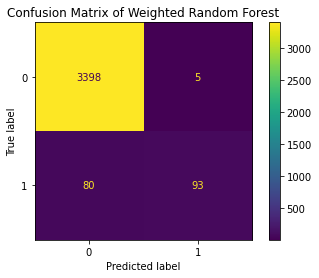

In [ ]:
# random forest classifiers
pipe_default_rfc, preds_default_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', num_components=100)
pipe_ros_rfc, preds_ros_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'ROS', num_components=100)
pipe_smote_rfc, preds_smote_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'SMOTE', num_components=100)
pipe_weighted_rfc, preds_weighted_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'Weighted', num_components=100)

### Method 2 — SVM


SVM
	Development accuracy: 0.9671
	Development recall: 0.3203
	Test accuracy: 0.9662
	Test recall: 0.3006


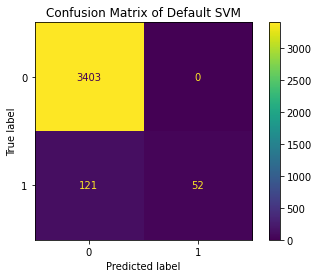


SVM
+ Random Over Sampler
	Development accuracy: 0.9491
	Development recall: 0.9957
	Test accuracy: 0.9418
	Test recall: 0.8150


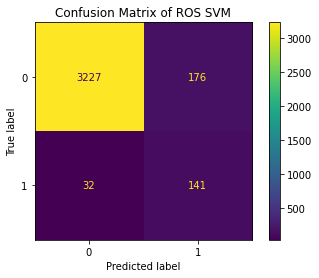


SVM
+ SMOTE
	Development accuracy: 0.9509
	Development recall: 0.9827
	Test accuracy: 0.9427
	Test recall: 0.7919


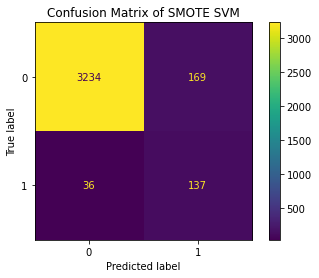


SVM
+ 'balanced' Class Weights
	Development accuracy: 0.9218
	Development recall: 0.9870
	Test accuracy: 0.9181
	Test recall: 0.8382


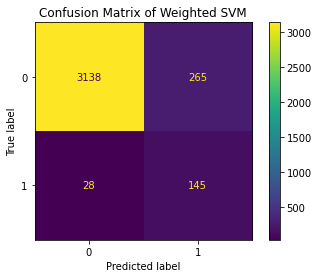

In [ ]:
# SVM classifiers
pipe_ros_svm, preds_ros_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', num_components=100)
pipe_ros_svm, preds_ros_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'ROS', num_components=100)
pipe_smote_svm, preds_smote_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'SMOTE', num_components=100)
pipe_weighted_svm, preds_weighted_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'Weighted', num_components=100)


### Method 2 — Performance Curves

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

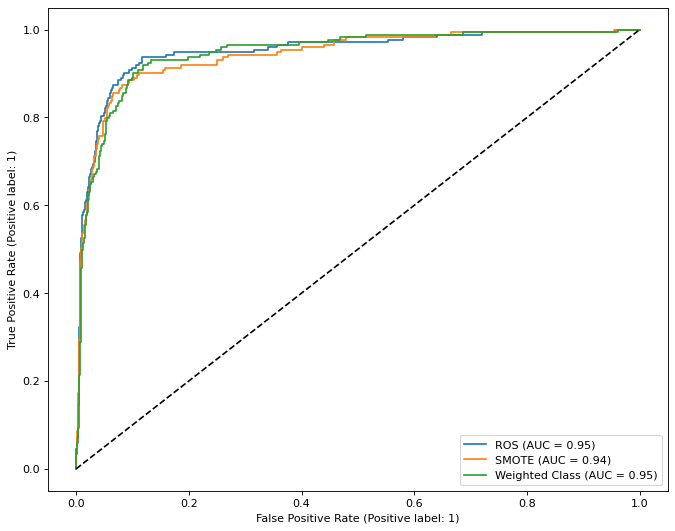

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

from sklearn.metrics import plot_roc_curve

classifiers = [pipe_ros_svm, pipe_smote_svm, pipe_weighted_svm]
name = ["ROS", "SMOTE", "Weighted Class"]

ax = plt.gca()
for index in range(len(classifiers)):
    plot_roc_curve(classifiers[index], X_test_text, y_test_text, ax = ax, name= name[index])
plt.plot([0,1],[0,1], 'k--')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

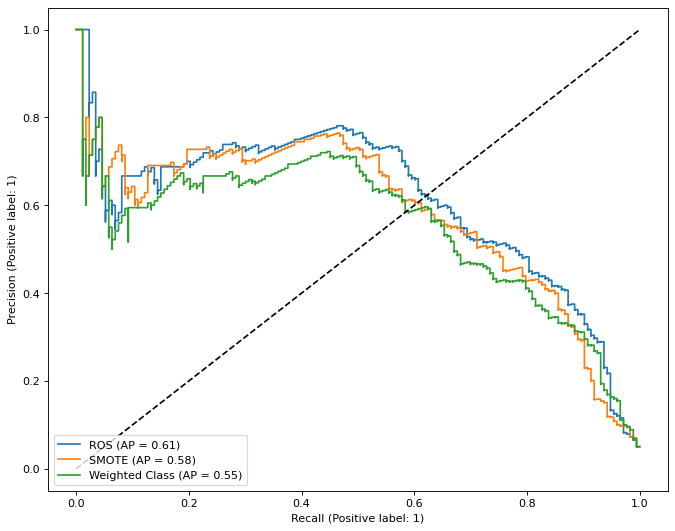

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

from sklearn.metrics import plot_precision_recall_curve

classifiers = [pipe_ros_svm, pipe_smote_svm, pipe_weighted_svm]
name = ["ROS", "SMOTE", "Weighted Class"]

ax = plt.gca()
for index in range(len(classifiers)):
    plot_precision_recall_curve(classifiers[index], X_test_text, y_test_text, ax = ax, name= name[index])
plt.plot([0,1],[0,1], 'k--')

## Method 3: Using TF-IDF Vectorizer

In [ ]:
postings_count = pd.concat([postings, postings_all_text], axis= 1)

In [ ]:
postings_count_dev, postings_count_test = train_test_split(postings_count, test_size=0.2, random_state=42, stratify = postings_count['fraudulent'])

In [ ]:
from category_encoders import TargetEncoder

target_encoder = TargetEncoder()
postings_count_dev[categorical_target_columns] = target_encoder.fit_transform(postings_count_dev[categorical_target_columns], postings_count_dev['fraudulent'])
postings_count_test[categorical_target_columns] = target_encoder.transform(postings_count_test[categorical_target_columns], postings_count_test['fraudulent'])

In [ ]:
X_dev_text = postings_count_dev.drop(columns=['fraudulent'])
y_dev_text = postings_count_dev['fraudulent']

X_test_text = postings_count_test.drop(columns=['fraudulent'])
y_test_text = postings_count_test['fraudulent']

In [ ]:
vector_words = TfidfVectorizer(stop_words='english', min_df=100, max_features=128)
X_dev_embeddings = vector_words.fit_transform(X_dev_text['lemmas'].reset_index()['lemmas'])
X_test_embeddings = vector_words.transform(X_test_text['lemmas'].reset_index()['lemmas'])

In [ ]:
X_dev_text = pd.concat([X_dev_text.reset_index(), pd.DataFrame(X_dev_embeddings.toarray())], axis=1)
X_test_text = pd.concat([X_test_text.reset_index(), pd.DataFrame(X_test_embeddings.toarray())], axis=1)

In [ ]:
X_dev_text.drop(columns=['lemmas', 'all_text', 'index'], inplace=True, errors='ignore')
X_test_text.drop(columns=['lemmas', 'all_text', 'index'], inplace=True, errors='ignore')

In [ ]:
feature_names = list(X_dev_text.columns.values)

In [ ]:
X_dev_text = np.array(X_dev_text)
X_test_text = np.array(X_test_text)

### Method 3 — Logistic Regression


Logistic Regression
	Development accuracy: 0.9741
	Development recall: 0.5368
	Test accuracy: 0.9678
	Test recall: 0.4162


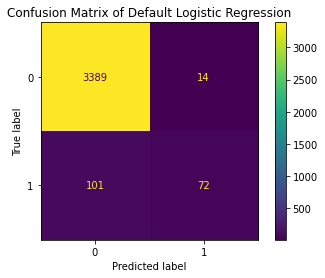


Logistic Regression
+ Random Over Sampler
	Development accuracy: 0.9194
	Development recall: 0.9250
	Test accuracy: 0.9234
	Test recall: 0.8786


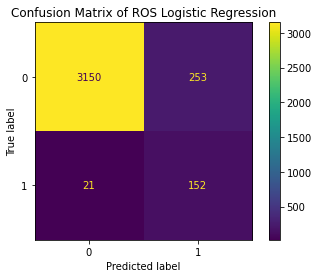


Logistic Regression
+ SMOTE
	Development accuracy: 0.9283
	Development recall: 0.9105
	Test accuracy: 0.9304
	Test recall: 0.8613


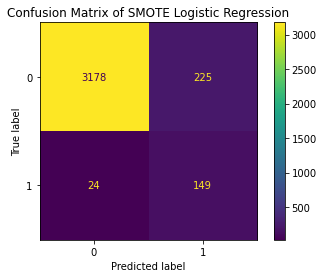


Logistic Regression
+ 'balanced' Class Weights
	Development accuracy: 0.9741
	Development recall: 0.5368
	Test accuracy: 0.9678
	Test recall: 0.4162


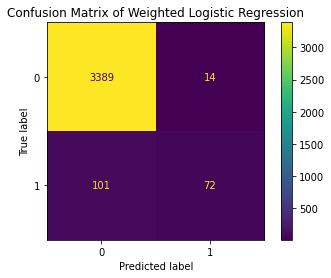

In [ ]:
# Logistic Regression
pipe_default_lr, preds_default_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr')
pipe_ros_lr, preds_ros_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'ROS')
pipe_smote_lr, preds_smote_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'SMOTE')
pipe_weighted_lr, preds_weighted_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'Weighted')

### Method 3 — K-Nearest Neighbors


KNN
	Development accuracy: 0.9873
	Development recall: 0.8095
	Test accuracy: 0.9776
	Test recall: 0.6590


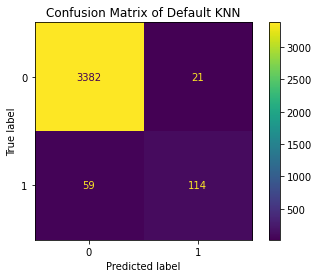


KNN
+ Random Over Sampler
	Development accuracy: 0.9849
	Development recall: 1.0000
	Test accuracy: 0.9715
	Test recall: 0.8092


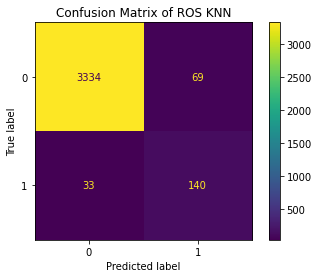


KNN
+ SMOTE
	Development accuracy: 0.9604
	Development recall: 1.0000
	Test accuracy: 0.9326
	Test recall: 0.9075


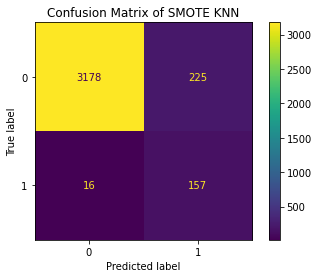


KNN
+ 'balanced' Class Weights
	Development accuracy: 0.9873
	Development recall: 0.8095
	Test accuracy: 0.9776
	Test recall: 0.6590


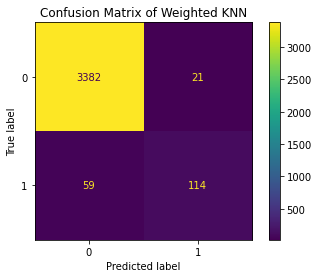

In [ ]:
# KNN
pipe_default_knn, preds_default_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn')
pipe_ros_knn, preds_ros_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'ROS')
pipe_smote_knn, preds_smote_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'SMOTE')
pipe_weighted_knn, preds_weighted_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'Weighted')

### Method 3 — Decision Trees


Decision Tree Classifier
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9701
	Test recall: 0.6590


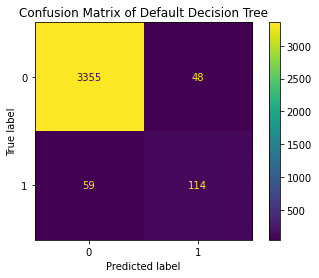


Decision Tree Classifier
+ Random Over Sampler
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9603
	Test recall: 0.6069


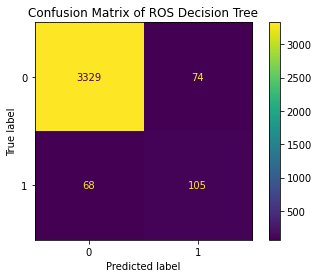


Decision Tree Classifier
+ SMOTE
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9539
	Test recall: 0.6590


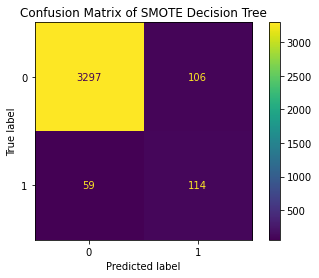


Decision Tree Classifier
+ 'balanced' Class Weights
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9581
	Test recall: 0.6012


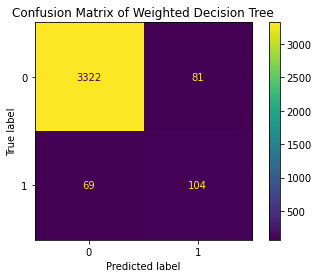

In [ ]:
# decision tree classifiers
pipe_default_dtc, preds_default_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', num_components=100)
pipe_ros_dtc, preds_ros_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'ROS', num_components=100)
pipe_smote_dtc, preds_smote_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'SMOTE', num_components=100)
pipe_weighted_dtc, preds_weighted_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'Weighted', num_components=100)

### Method 3 — Random Forest


Random Forest Classifier
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9801
	Test recall: 0.5954


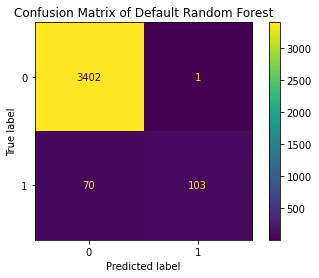


Random Forest Classifier
+ Random Over Sampler
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9796
	Test recall: 0.6127


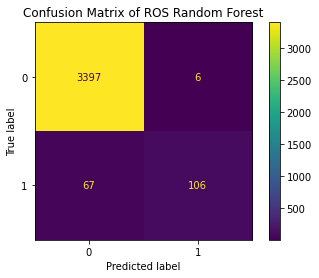


Random Forest Classifier
+ SMOTE
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9815
	Test recall: 0.6763


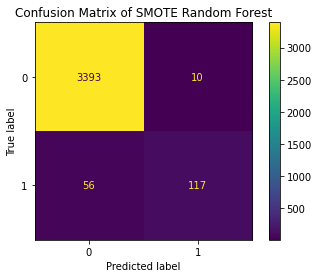


Random Forest Classifier
+ 'balanced' Class Weights
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9762
	Test recall: 0.5260


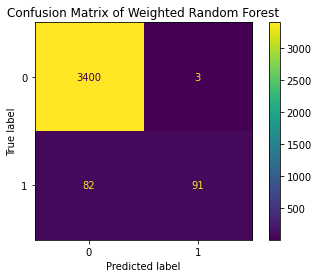

In [ ]:
# random forest classifiers
pipe_default_rfc, preds_default_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', num_components=100)
pipe_ros_rfc, preds_ros_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'ROS', num_components=100)
pipe_smote_rfc, preds_smote_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'SMOTE', num_components=100)
pipe_weighted_rfc, preds_weighted_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'Weighted', num_components=100)

### Method 3 — SVM


SVM
	Development accuracy: 0.9773
	Development recall: 0.5527
	Test accuracy: 0.9715
	Test recall: 0.4393


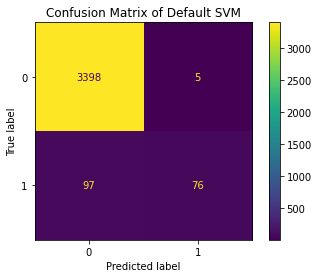


SVM
+ Random Over Sampler
	Development accuracy: 0.9734
	Development recall: 0.9971
	Test accuracy: 0.9687
	Test recall: 0.8728


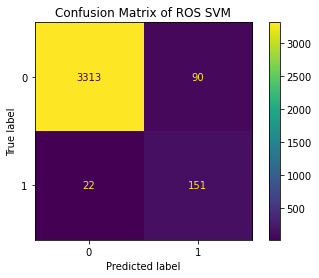


SVM
+ SMOTE
	Development accuracy: 0.9796
	Development recall: 0.9841
	Test accuracy: 0.9729
	Test recall: 0.8439


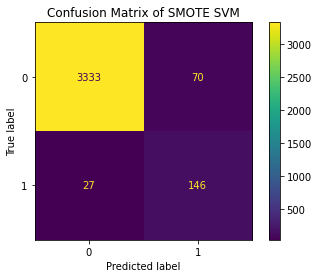


SVM
+ 'balanced' Class Weights
	Development accuracy: 0.9556
	Development recall: 0.9827
	Test accuracy: 0.9539
	Test recall: 0.8844


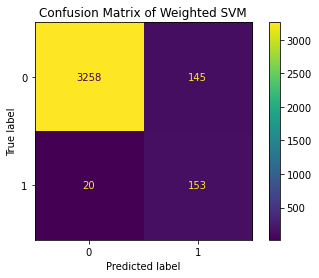

In [ ]:
# SVM classifiers
pipe_ros_svm, preds_ros_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', num_components=100)
pipe_ros_svm, preds_ros_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'ROS', num_components=100)
pipe_smote_svm, preds_smote_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'SMOTE', num_components=100)
pipe_weighted_svm, preds_weighted_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'Weighted', num_components=100)


### Method 3 — Performance Curves

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

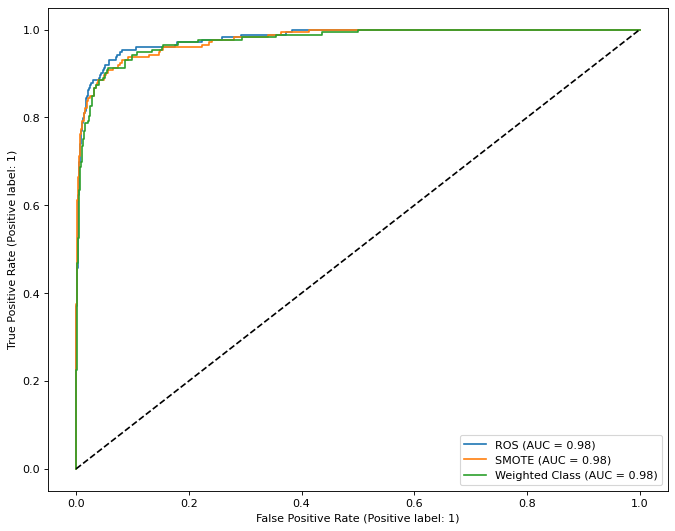

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

from sklearn.metrics import plot_roc_curve

classifiers = [pipe_ros_svm, pipe_smote_svm, pipe_weighted_svm]
name = ["ROS", "SMOTE", "Weighted Class"]

ax = plt.gca()
for index in range(len(classifiers)):
    plot_roc_curve(classifiers[index], X_test_text, y_test_text, ax = ax, name= name[index])
plt.plot([0,1],[0,1], 'k--')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

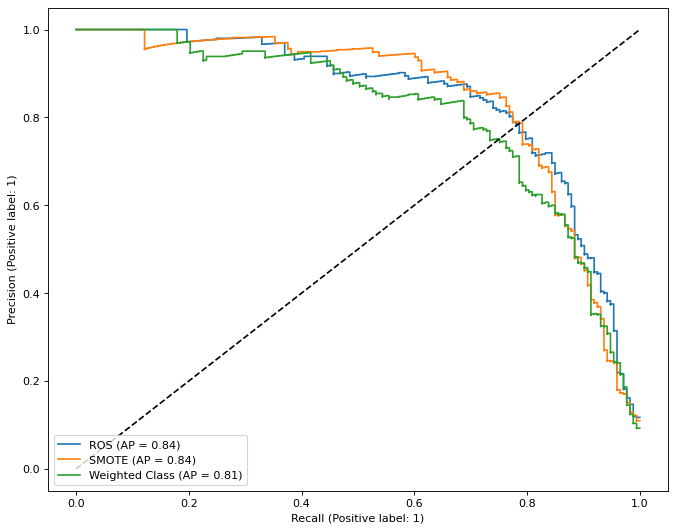

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

from sklearn.metrics import plot_precision_recall_curve

classifiers = [pipe_ros_svm, pipe_smote_svm, pipe_weighted_svm]
name = ["ROS", "SMOTE", "Weighted Class"]

ax = plt.gca()
for index in range(len(classifiers)):
    plot_precision_recall_curve(classifiers[index], X_test_text, y_test_text, ax = ax, name= name[index])
plt.plot([0,1],[0,1], 'k--')

## Method 4: Using BERT Vectorizer

In [ ]:
descriptions_output = np.load(os.path.join(path, foldername, 'alltext.npy'))

In [ ]:
postings_count = pd.concat([postings, pd.DataFrame(descriptions_output)], axis=1)

In [ ]:
postings_count_dev, postings_count_test = train_test_split(postings_count, test_size=0.2, random_state=42, stratify = postings_count['fraudulent'])

In [ ]:
from category_encoders import TargetEncoder

target_encoder = TargetEncoder()
postings_count_dev[categorical_target_columns] = target_encoder.fit_transform(postings_count_dev[categorical_target_columns], postings_count_dev['fraudulent'])
postings_count_test[categorical_target_columns] = target_encoder.transform(postings_count_test[categorical_target_columns], postings_count_test['fraudulent'])

In [ ]:
X_dev_text = postings_count_dev.drop(columns=['fraudulent'])
y_dev_text = postings_count_dev['fraudulent']

X_test_text = postings_count_test.drop(columns=['fraudulent'])
y_test_text = postings_count_test['fraudulent']

In [ ]:
X_dev_text.drop(columns=['lemmas', 'all_text', 'index'], inplace=True, errors='ignore')
X_test_text.drop(columns=['lemmas', 'all_text', 'index'], inplace=True, errors='ignore')

In [ ]:
X_dev_text = np.array(X_dev_text)
X_test_text = np.array(X_test_text)

### Method 4 — Logistic Regression


Logistic Regression
	Development accuracy: 0.9725
	Development recall: 0.5180
	Test accuracy: 0.9670
	Test recall: 0.3757


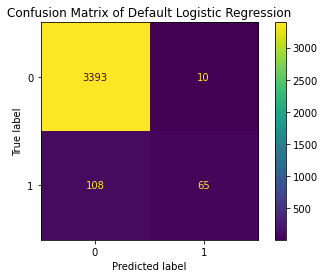


Logistic Regression
+ Random Over Sampler


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


	Development accuracy: 0.9075
	Development recall: 0.9062
	Test accuracy: 0.9044
	Test recall: 0.7977


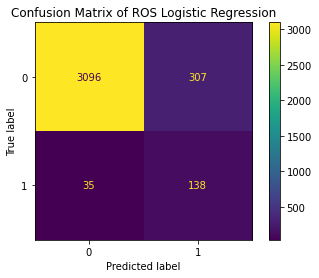


Logistic Regression
+ SMOTE
	Development accuracy: 0.9177
	Development recall: 0.8889
	Test accuracy: 0.9150
	Test recall: 0.7861


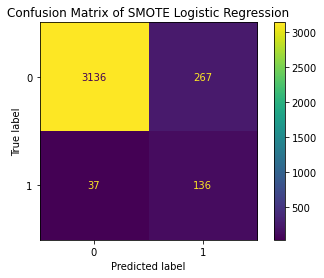


Logistic Regression
+ 'balanced' Class Weights
	Development accuracy: 0.9725
	Development recall: 0.5180
	Test accuracy: 0.9670
	Test recall: 0.3757


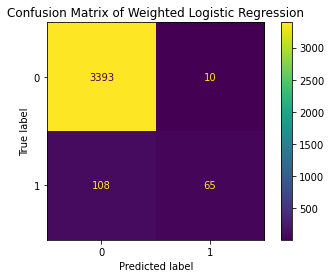

In [ ]:
# Logistic Regression
pipe_default_lr, preds_default_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr')
pipe_ros_lr, preds_ros_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'ROS')
pipe_smote_lr, preds_smote_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'SMOTE')
pipe_weighted_lr, preds_weighted_lr = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'lr', 'Weighted')

### Method 4 — K-Nearest Neighbors


KNN
	Development accuracy: 0.9842
	Development recall: 0.7460
	Test accuracy: 0.9734
	Test recall: 0.6185


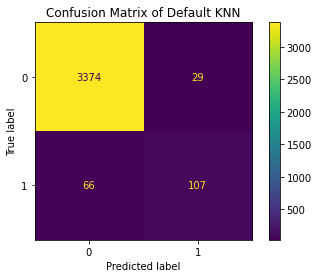


KNN
+ Random Over Sampler
	Development accuracy: 0.9870
	Development recall: 1.0000
	Test accuracy: 0.9628
	Test recall: 0.7630


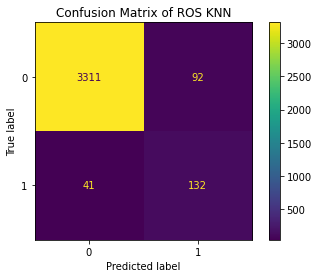


KNN
+ SMOTE
	Development accuracy: 0.9602
	Development recall: 1.0000
	Test accuracy: 0.9320
	Test recall: 0.8786


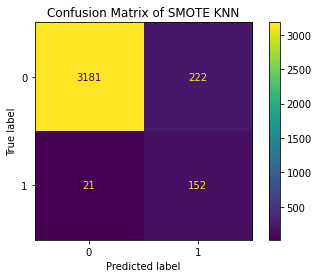


KNN
+ 'balanced' Class Weights
	Development accuracy: 0.9842
	Development recall: 0.7460
	Test accuracy: 0.9734
	Test recall: 0.6185


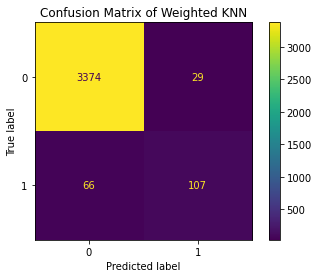

In [ ]:
# KNN
pipe_default_knn, preds_default_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn')
pipe_ros_knn, preds_ros_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'ROS')
pipe_smote_knn, preds_smote_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'SMOTE')
pipe_weighted_knn, preds_weighted_knn = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'knn', 'Weighted')

### Method 4 — Decision Trees


Decision Tree Classifier
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9673
	Test recall: 0.6821


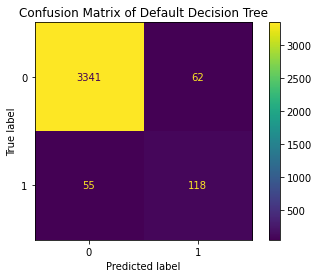


Decision Tree Classifier
+ Random Over Sampler
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9639
	Test recall: 0.6243


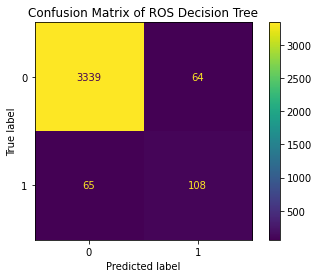


Decision Tree Classifier
+ SMOTE
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9564
	Test recall: 0.6647


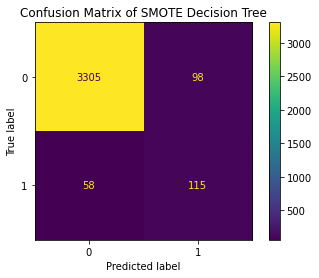


Decision Tree Classifier
+ 'balanced' Class Weights
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9609
	Test recall: 0.6127


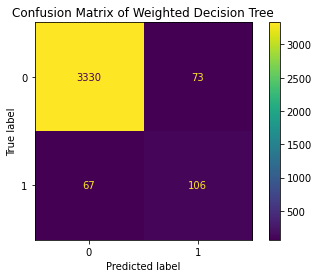

In [ ]:
# decision tree classifiers
pipe_default_dtc, preds_default_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', num_components=100)
pipe_ros_dtc, preds_ros_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'ROS', num_components=100)
pipe_smote_dtc, preds_smote_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'SMOTE', num_components=100)
pipe_weighted_dtc, preds_weighted_dtc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text, 'dtc', 'Weighted', num_components=100)

### Method 4 — Random Forest


Random Forest Classifier
	Development accuracy: 0.9999
	Development recall: 0.9986
	Test accuracy: 0.9790
	Test recall: 0.5665


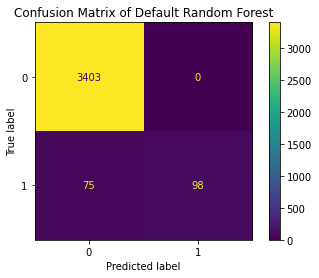


Random Forest Classifier
+ Random Over Sampler
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9796
	Test recall: 0.5838


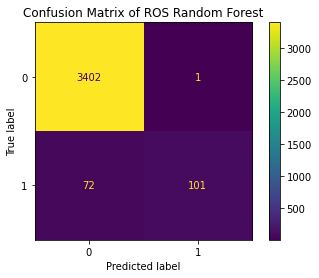


Random Forest Classifier
+ SMOTE
	Development accuracy: 1.0000
	Development recall: 1.0000
	Test accuracy: 0.9807
	Test recall: 0.6763


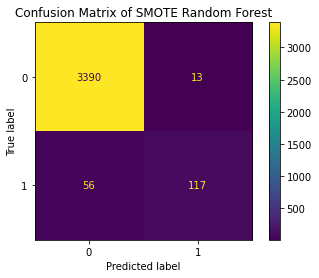


Random Forest Classifier
+ 'balanced' Class Weights
	Development accuracy: 0.9999
	Development recall: 0.9986
	Test accuracy: 0.9762
	Test recall: 0.5087


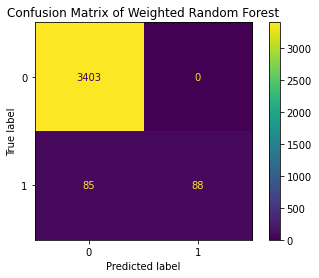

In [ ]:
# random forest classifiers
pipe_default_rfc, preds_default_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', num_components=100)
pipe_ros_rfc, preds_ros_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'ROS', num_components=100)
pipe_smote_rfc, preds_smote_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'SMOTE', num_components=100)
pipe_weighted_rfc, preds_weighted_rfc = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'rfc', 'Weighted', num_components=100)

### Method 4 — SVM


SVM
	Development accuracy: 0.9635
	Development recall: 0.2496
	Test accuracy: 0.9603
	Test recall: 0.1908


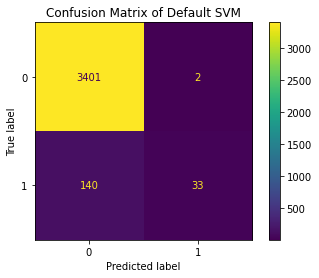


SVM
+ Random Over Sampler
	Development accuracy: 0.9279
	Development recall: 0.9437
	Test accuracy: 0.9200
	Test recall: 0.8439


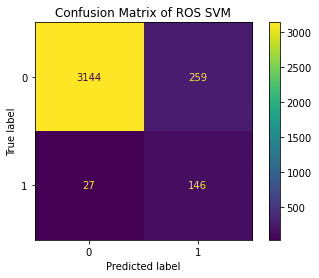


SVM
+ SMOTE
	Development accuracy: 0.9437
	Development recall: 0.9134
	Test accuracy: 0.9334
	Test recall: 0.8035


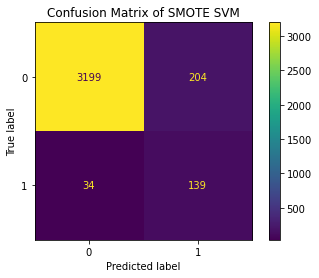


SVM
+ 'balanced' Class Weights
	Development accuracy: 0.9156
	Development recall: 0.9322
	Test accuracy: 0.9108
	Test recall: 0.8382


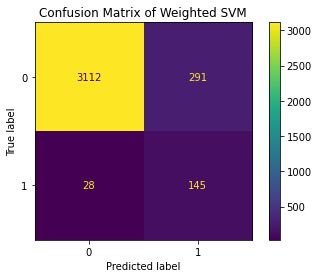

In [ ]:
# SVM classifiers
pipe_ros_svm, preds_ros_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', num_components=100)
pipe_ros_svm, preds_ros_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'ROS', num_components=100)
pipe_smote_svm, preds_smote_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'SMOTE', num_components=100)
pipe_weighted_svm, preds_weighted_svm = buildTrainEvaluate(X_dev_text, y_dev_text, X_test_text, y_test_text,'svm', 'Weighted', num_components=100)


### Method 4 — Performance Curves

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

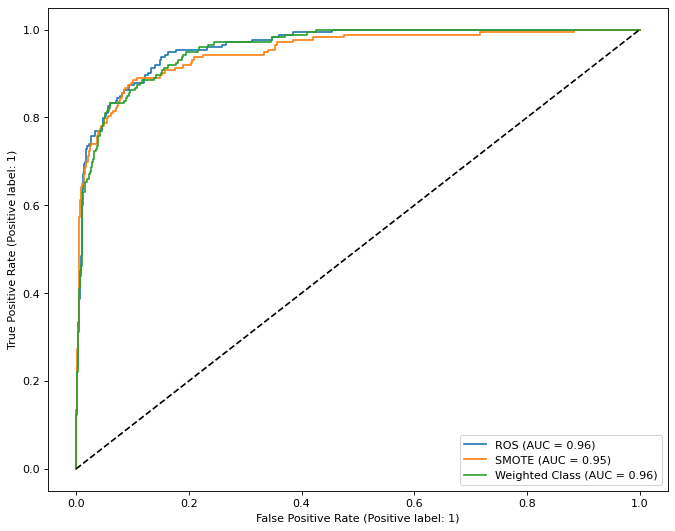

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

from sklearn.metrics import plot_roc_curve

classifiers = [pipe_ros_svm, pipe_smote_svm, pipe_weighted_svm]
name = ["ROS", "SMOTE", "Weighted Class"]

ax = plt.gca()
for index in range(len(classifiers)):
    plot_roc_curve(classifiers[index], X_test_text, y_test_text, ax = ax, name= name[index])
plt.plot([0,1],[0,1], 'k--')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

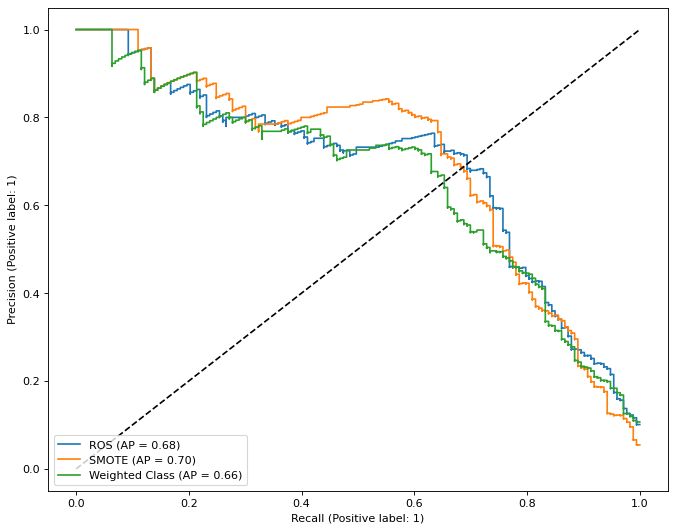

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

from sklearn.metrics import plot_precision_recall_curve

classifiers = [pipe_ros_svm, pipe_smote_svm, pipe_weighted_svm]
name = ["ROS", "SMOTE", "Weighted Class"]

ax = plt.gca()
for index in range(len(classifiers)):
    plot_precision_recall_curve(classifiers[index], X_test_text, y_test_text, ax = ax, name= name[index])
plt.plot([0,1],[0,1], 'k--')